# Social Network Analysis Project - International Trade Flows Dataset 

In [59]:
import math
import cpnet
import functools
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

THRESHOLD = 1.0
PRODUCT = "Coal"
DATASET_PATH = "DatasetWithCountries.xlsx"





### Reading and cleaning the dataset

In [2]:
df = pd.read_excel(DATASET_PATH)
df = df[df["Value (thousands USD)"] > THRESHOLD]
df['ContinentExporter'] = df['ContinentExporter'].fillna("NA")
df['ContinentImporter'] = df['ContinentImporter'].fillna("NA")

df.head()

,Exporter,Importer,Product,Value (thousands USD),ContinentExporter,ContinentImporter
2,ALB,CZE,Eng,3382.312,EU,EU
3,ALB,GRC,Eng,41847.186,EU,EU
4,ALB,ITA,Oil,13472.550,EU,EU
5,ALB,SRB,Coal,33.708,EU,EU
6,ALB,SRB,Eng,5223.920,EU,EU


In [3]:
print("Min value: ", df["Value (thousands USD)"].min())
print("Max value: ", df["Value (thousands USD)"].max())

Min value:  1.006
Max value:  45469956.717


## Analyze based on Product 

In [4]:
df_product = df[df["Product"] == PRODUCT]
df_product.head()

,Exporter,Importer,Product,Value (thousands USD),ContinentExporter,ContinentImporter
5,ALB,SRB,Coal,33.708,EU,EU
87,AZE,GEO,Coal,43.500,AS,AS
118,ARG,BRA,Coal,229.782,SA,SA
123,ARG,CHL,Coal,1022.578,SA,SA
130,ARG,PRY,Coal,56.766,SA,SA


### Find Nodes and Edges of the selected product

In [5]:
product_nodes = list(set(df_product["Exporter"].unique().tolist() + df_product["Importer"].unique().tolist()))

continent_mapping = {}
for (index, row) in df_product.iterrows():
    continent_mapping[row["Exporter"]] = row["ContinentExporter"]
    continent_mapping[row["Importer"]] = row["ContinentImporter"]

product_edges = [(row["Exporter"], row["Importer"], row["Value (thousands USD)"]) for (index, row) in df_product.iterrows()]


## Creating corresponding graph

In [6]:
G_product = nx.DiGraph()

G_product.add_nodes_from(product_nodes)
for node in G_product.nodes():
    G_product.nodes[node]["Continent"] = continent_mapping[node]

G_product.add_weighted_edges_from(product_edges)

inverse_weights = {}
for u, v, d in G_product.edges(data=True):
    inverse_weights[(u,v)] = math.log(d["weight"]+1)
    
nx.set_edge_attributes(G_product, inverse_weights, name="inverse_weights")


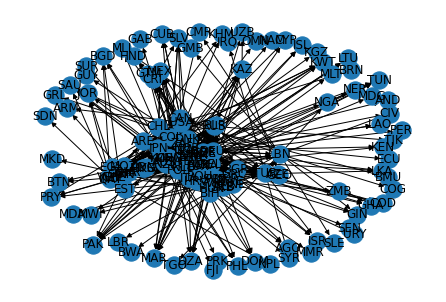

In [7]:
nx.draw(G_product, with_labels=True)

## Degree centrality

In [8]:
out_degree_centrality_list = sorted(nx.out_degree_centrality(G_product).items(), key=lambda item: item[1], reverse=True)
out_degree_centrality_list[:10]

[('CHN', 0.43478260869565216),
 ('POL', 0.37681159420289856),
 ('DEU', 0.32608695652173914),
 ('RUS', 0.2898550724637681),
 ('USA', 0.2463768115942029),
 ('ITA', 0.2391304347826087),
 ('COL', 0.2246376811594203),
 ('CZE', 0.2246376811594203),
 ('ESP', 0.21014492753623187),
 ('GBR', 0.18115942028985507)]

In [9]:
in_degree_centrality_list = sorted(nx.in_degree_centrality(G_product).items(), key=lambda item: item[1], reverse=True)
in_degree_centrality_list[:10]

[('IND', 0.18115942028985507),
 ('DEU', 0.13768115942028986),
 ('FRA', 0.13768115942028986),
 ('NLD', 0.13768115942028986),
 ('GBR', 0.13043478260869565),
 ('ESP', 0.12318840579710146),
 ('CHN', 0.11594202898550725),
 ('BEL', 0.11594202898550725),
 ('MYS', 0.10869565217391304),
 ('USA', 0.09420289855072464)]

## Strenght Centralities

In [16]:
# Custom function to calculate the strenght centrality
def strength_centrality(G, out=True): 
    strengths = dict()
    sum_of_weights = 0
    for node in G.nodes:
        strengths[node] = 0
    for u, v, d in G.edges(data=True):
        if not out:
            k = v
            v = u
            u = k
        strengths[u] += d["weight"]
        sum_of_weights += d["weight"]
    
    for key in strengths.keys():
        strengths[key] = strengths[key] / sum_of_weights
        
    return sorted(strengths.items(), key=lambda item: item[1], reverse=True)

### Out Strenght Centralities

In [17]:
out_strengths_centrality_list = strength_centrality(G_product, out=True)
out_strengths_centrality_list[:10]

[('POL', 0.25094190709138764),
 ('CHN', 0.14567359952310208),
 ('JPN', 0.11677536622331738),
 ('COL', 0.11658506686042935),
 ('RUS', 0.10397322368306111),
 ('DEU', 0.04570667004772723),
 ('USA', 0.033133994427504934),
 ('CZE', 0.02864557479418145),
 ('AUS', 0.023161629300708753),
 ('BIH', 0.016555099515807154)]

### In Strenght Centralities

In [18]:
in_strengths_centrality_list = strength_centrality(G_product, out=False)
in_degree_centrality_list[:10]

[('IND', 0.18115942028985507),
 ('DEU', 0.13768115942028986),
 ('FRA', 0.13768115942028986),
 ('NLD', 0.13768115942028986),
 ('GBR', 0.13043478260869565),
 ('ESP', 0.12318840579710146),
 ('CHN', 0.11594202898550725),
 ('BEL', 0.11594202898550725),
 ('MYS', 0.10869565217391304),
 ('USA', 0.09420289855072464)]

## Closeness centrality

In [20]:
closeness_centrality_list = sorted(nx.closeness_centrality(G_product, distance="inverse_weights").items(), key=lambda item: item[1], reverse=True)
closeness_centrality_list[:10]

[('NLD', 0.07139699802305303),
 ('SGP', 0.06682238574677327),
 ('TUR', 0.06389358855383666),
 ('CHE', 0.06231795756799982),
 ('BGR', 0.06209099601316599),
 ('CRI', 0.05955313841078842),
 ('IND', 0.05919489194857846),
 ('ROU', 0.058053546589702056),
 ('BGD', 0.056727425905378374),
 ('ISR', 0.05615977738130137)]

## Betweeness Centrality

In [21]:
betweeness_centrality_list = sorted(nx.betweenness_centrality(G_product, weight="inverse_weights").items(), key=lambda item: item[1], reverse=True)
betweeness_centrality_list[:10]

[('CHN', 0.10800803977573256),
 ('USA', 0.0804506505871152),
 ('DEU', 0.06923727917063366),
 ('NLD', 0.06786205437427272),
 ('IND', 0.0633661271554004),
 ('BEL', 0.05696604252618216),
 ('GBR', 0.0535808737966783),
 ('TUR', 0.050037025282978945),
 ('LBN', 0.04845022744102401),
 ('ESP', 0.047339468951655556)]

## Pagerank

In [22]:
pagerank_list = sorted(nx.pagerank(G_product, weight="weight").items(), key=lambda item: item[1], reverse=True)
pagerank_list[:10]

[('FRA', 0.04891677435275397),
 ('ITA', 0.0451570755800339),
 ('IND', 0.04083953287480624),
 ('BTN', 0.03215332279365746),
 ('CHN', 0.03159626204567659),
 ('ESP', 0.028786591256344352),
 ('GEO', 0.027212267453544853),
 ('AZE', 0.026299147067356022),
 ('IDN', 0.0251102368286571),
 ('DEU', 0.022233415235011763)]

## Assortative mixing

In [23]:
nx.attribute_assortativity_coefficient(G_product, attribute="Continent")

0.3533672612283214

## Assortativity by degree

In [24]:
nx.degree_assortativity_coefficient(G_product)

-0.10564216260298649

## Core-Periphery

In [26]:
algorithm = cpnet.LapCore()
algorithm.detect(G_product)

groups = algorithm.get_pair_id()
coreness = algorithm.get_coreness()

print("Groups")
#print([(c, groups[c]) for c in groups.keys() if groups[c]!=0])
print(groups)
print()
print("Coreness=1")
print([(c, coreness[c]) for c in coreness.keys() if coreness[c]==1])
print("Coreness=0")
print([(c, coreness[c]) for c in coreness.keys() if coreness[c]==0])

Groups
{'LVA': 0, 'IND': 0, 'DZA': 0, 'PHL': 0, 'HND': 0, 'HKG': 0, 'MNE': 0, 'QAT': 0, 'AZE': 0, 'SGP': 0, 'KWT': 0, 'ECU': 0, 'SYR': 0, 'PRY': 0, 'SAU': 0, 'GRC': 0, 'MKD': 0, 'CHL': 0, 'EGY': 0, 'CRI': 0, 'GUY': 0, 'GIN': 0, 'ARM': 0, 'FIN': 0, 'ROU': 0, 'NGA': 0, 'KHM': 0, 'CMR': 0, 'ESP': 0, 'PER': 0, 'BMU': 0, 'IDN': 0, 'RUS': 0, 'IRL': 0, 'COL': 0, 'LAO': 0, 'DNK': 0, 'BGD': 0, 'GTM': 0, 'DEU': 0, 'MDG': 0, 'LKA': 0, 'BRA': 0, 'BGR': 0, 'DOM': 0, 'GMB': 0, 'LBR': 0, 'IRQ': 0, 'MLT': 0, 'SUR': 0, 'OMN': 0, 'ZAF': 0, 'LTU': 0, 'SRB': 0, 'PRT': 0, 'AUS': 0, 'MWI': 0, 'VEN': 0, 'KOR': 0, 'NZL': 0, 'PAN': 0, 'BWA': 0, 'MAR': 0, 'USA': 0, 'MMR': 0, 'MLI': 0, 'MNG': 0, 'CZE': 0, 'BTN': 0, 'TUN': 0, 'CHN': 0, 'UKR': 0, 'JPN': 0, 'TGO': 0, 'SVN': 0, 'GAB': 0, 'FRA': 0, 'SEN': 0, 'SLV': 0, 'BIH': 0, 'GBR': 0, 'COD': 0, 'NAM': 0, 'ZMB': 0, 'BLR': 0, 'URY': 0, 'POL': 0, 'BEL': 0, 'HRV': 0, 'CAN': 0, 'ARG': 0, 'EST': 0, 'GHA': 0, 'ISL': 0, 'LBN': 0, 'AUT': 0, 'CUB': 0, 'MEX': 0, 'CYP': 0, 'A

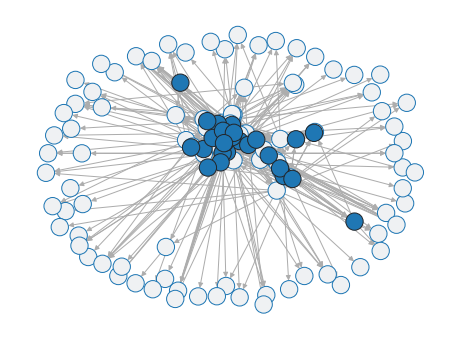

In [27]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
ax, pos = cpnet.draw(G_product, groups, coreness, ax)

# New graph with total flow in USD 

In [3]:
df_total = df.groupby(['Exporter','Importer'])['Value (thousands USD)'].sum().reset_index()
df_total

,Exporter,Importer,Value (thousands USD)
0,ABW,KOR,7.491343e+04
1,AGO,BEL,2.296520e+02
2,AGO,BRA,3.059060e+04
3,AGO,CHL,6.786450e+04
4,AGO,CHN,1.260183e+07
...,...,...,...
1932,ZWE,MWI,3.417301e+03
1933,ZWE,NAM,5.086895e+03
1934,ZWE,SWZ,8.320575e+03
1935,ZWE,ZAF,9.598700e+03


In [4]:
totalUSD_nodes = list(set(df_total["Exporter"].unique().tolist() + df_total["Importer"].unique().tolist()))

totalUSD_edges = [(row["Exporter"], row["Importer"], row["Value (thousands USD)"]) for (index, row) in df_total.iterrows()]

## Create Total Graph

In [30]:
G_total = nx.DiGraph()
G_total.add_nodes_from(totalUSD_nodes)
G_total.add_weighted_edges_from(totalUSD_edges)

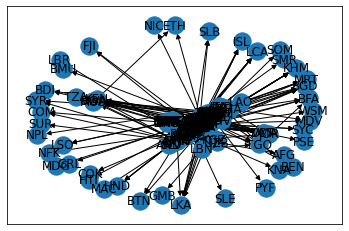

In [31]:
nx.draw_networkx(G_total,with_labels=True)

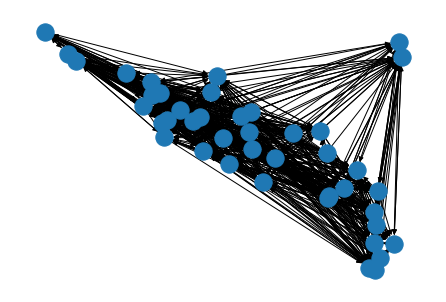

In [32]:
nx.draw(nx.k_core(G_total))

## Clustering coefficient for each node (local)

In [ ]:
sorted(nx.clustering(G_total).items(), key=lambda item: item[1], reverse=True)

## Average Clustering coefficient

In [ ]:
nx.average_clustering(G_total)

## Transitivity

In [ ]:
nx.transitivity(G_total)

## Reciprocity on the whole network

In [ ]:
nx.reciprocity(G_total)

# Create another total graph to study Cliques and Components

In [62]:
def filter_node(n, node_list):
    if n in node_list:
        return True
    else:
        return False
    
def filter_edge(e1,e2, node_list):
    if e1 in node_list or e2 in node_list:
        return True
    else:
        return False

In [ ]:
totalValuesUSD = {}
for (index, row) in df_total.iterrows():
    totalValuesUSD[(row["Exporter"], row["Importer"])] = row["Value (thousands USD)"]

## First Approach: conservative
Here two countries A and B will have a link if and only if the flow from A to B is at least a third of the flow between B and A

In [19]:
archsCliqueGraph_cons = []
nodesCliqueGraph_cons = []
    
for exp, imp in totalValuesUSD.keys():
    if (imp, exp) in totalValuesUSD.keys() and min(totalValuesUSD[(exp,imp)], totalValuesUSD[(imp,exp)]) > max(totalValuesUSD[(exp,imp)], totalValuesUSD[(imp,exp)]) / 3 and not (imp,exp) in archsCliqueGraph_cons:
        print(f"{exp} exports {totalValuesUSD[(exp,imp)]} to {imp}")
        print(f"{imp} exports {totalValuesUSD[(imp,exp)]} to {exp}\n")
        archsCliqueGraph_cons.append((exp, imp))
        nodesCliqueGraph_cons.append(exp)
        nodesCliqueGraph_cons.append(imp)
        
nodesCliqueGraph_cons = list(set(nodesCliqueGraph_cons))

ALB exports 3382.312 to CZE
CZE exports 1722.352 to ALB

ALB exports 5257.628 to SRB
SRB exports 13244.275 to ALB

ALB exports 3488.104 to SVN
SVN exports 5245.365 to ALB

ARG exports 55455.391 to URY
URY exports 21449.005 to ARG

ARM exports 3178.658 to GEO
GEO exports 2577.421 to ARM

ARM exports 67797.872 to IRN
IRN exports 58514.351 to ARM

AUS exports 244998.655 to BRN
BRN exports 215050.258 to AUS

AUS exports 107.687 to DEU
DEU exports 54.008 to AUS

AUS exports 346924.687 to IDN
IDN exports 131095.63 to AUS

AUS exports 1089979.213 to MYS
MYS exports 1307805.674 to AUS

AUS exports 73823.494 to PNG
PNG exports 65461.099 to AUS

AUT exports 6696.523 to BGR
BGR exports 5108.755 to AUT

AUT exports 221016.67299999998 to CHE
CHE exports 101105.532 to AUT

AUT exports 313880.25200000004 to DEU
DEU exports 712253.1259999999 to AUT

AUT exports 2685.776 to FRA
FRA exports 926.84 to AUT

AUT exports 5961.559 to SWE
SWE exports 4995.055 to AUT

AZE exports 11912.354 to RUS
RUS exports 3

In [13]:
G_clique_cons = nx.Graph()

G_clique_cons.add_nodes_from(nodesCliqueGraph_cons)
G_clique_cons.add_edges_from(archsCliqueGraph_cons)

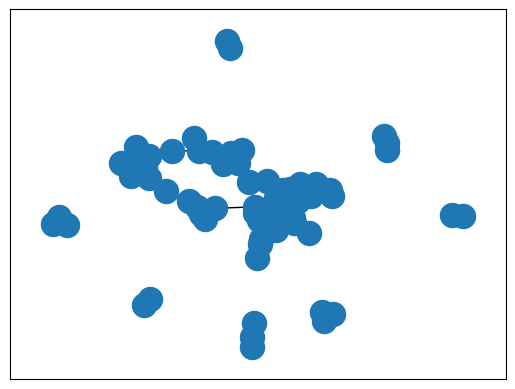

In [18]:
cliquesnx.draw_networkx(G_clique_cons,with_labels=False)

In [30]:
cliques_cons = list(nx.enumerate_all_cliques(G_clique_cons))
max_clique_size_cons = 0
for clique in cliques_cons:
    if len(clique) > max_clique_size_cons:
        max_clique_size_cons = len(clique)
for clique in cliques_cons:
    if len(clique) == max_clique_size_cons:
        print(clique)

['JPN', 'CHN', 'KOR']
['HUN', 'CZE', 'MKD']
['GBR', 'GRC', 'FRA']
['IDN', 'AUS', 'MYS']
['SGP', 'CHN', 'KOR']
['NOR', 'USA', 'BRA']
['ALB', 'SRB', 'CZE']
['MNE', 'SRB', 'CZE']
['MNE', 'CHE', 'CZE']
['ROU', 'SRB', 'BGR']
['TUR', 'CZE', 'BGR']
['SRB', 'CZE', 'BGR']
['SRB', 'CZE', 'MKD']
['CHE', 'CZE', 'DEU']
['CHE', 'DEU', 'AUT']
['CZE', 'DEU', 'POL']
['DEU', 'AUT', 'FRA']
['DEU', 'AUT', 'SWE']
['DEU', 'DNK', 'SWE']
['GRC', 'BGR', 'LUX']
['FRA', 'ESP', 'PRT']


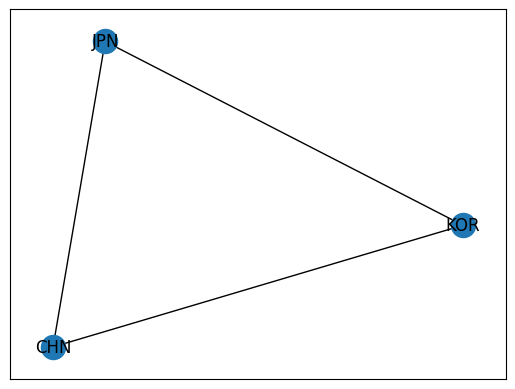

In [64]:
node_list_clique_cons = max(cliques_cons, key=len)

nx.draw_networkx(nx.subgraph_view(G_clique_cons, filter_node=functools.partial(filter_node, node_list=node_list_clique_cons), 
                                  filter_edge=functools.partial(filter_edge, node_list=node_list_clique_cons)))

And now we look for components

In [58]:
components_cons = [component for component in sorted(nx.connected_components(G_clique_cons), key=len, reverse=False)]
maximal_comp_cons = max(components_cons, key=len)
print(f"The maximal component has size {len(maximal_comp_cons)}")
print(maximal_comp_cons)

The maximal component has size 57
{'JPN', 'HUN', 'GBR', 'IDN', 'SGP', 'NOR', 'ALB', 'PHL', 'USA', 'MNE', 'BRA', 'ISR', 'TUR', 'ROU', 'BIH', 'BLR', 'ECU', 'SRB', 'COL', 'CHE', 'CZE', 'CHN', 'DEU', 'AUT', 'UKR', 'AUS', 'PNG', 'GRC', 'KOR', 'POL', 'MNG', 'LTU', 'BEL', 'EST', 'BGR', 'ITA', 'MLT', 'MAR', 'FRA', 'SVN', 'FIN', 'HRV', 'ESP', 'PAK', 'LUX', 'LVA', 'MEX', 'KWT', 'DNK', 'BRN', 'IRL', 'SWE', 'MKD', 'NLD', 'PRT', 'VNM', 'MYS'}


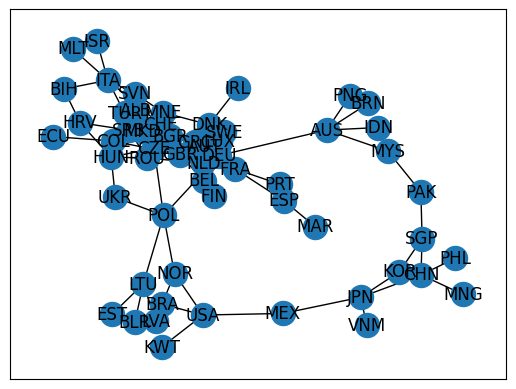

In [67]:
nx.draw_networkx(nx.subgraph_view(G_clique_cons, filter_node=functools.partial(filter_node, node_list=maximal_comp_cons), 
                                  filter_edge=functools.partial(filter_edge, node_list=maximal_comp_cons)), with_labels=True)

## Second approach: permissive
Here two countries A and B will have an edge if at least one exports to the other

In [20]:
archsCliqueGraph_perm = []
nodesCliqueGraph_perm = []
    
for exp, imp in totalValuesUSD.keys():
    if  not (imp,exp) in archsCliqueGraph_perm:
        archsCliqueGraph_perm.append((exp, imp))
        nodesCliqueGraph_perm.append(exp)
        nodesCliqueGraph_perm.append(imp)
        
nodesCliqueGraph_perm = list(set(nodesCliqueGraph_perm))

In [22]:
G_clique_perm = nx.Graph()

G_clique_perm.add_nodes_from(nodesCliqueGraph_perm)
G_clique_perm.add_edges_from(archsCliqueGraph_perm)

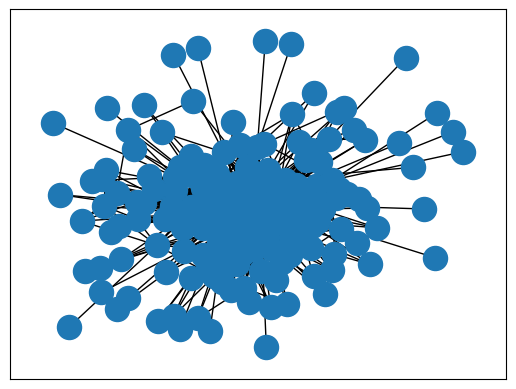

In [23]:
nx.draw_networkx(G_clique_perm,with_labels=False)

Now we look for cliques

In [44]:
cliques_perm = list(nx.enumerate_all_cliques(G_clique_perm))
max_clique_size_perm = 0
for clique in cliques_perm:
    if len(clique) > max_clique_size_perm:
        max_clique_size_perm = len(clique)
for clique in cliques_perm:
    if len(clique) == max_clique_size_perm:
        print(clique)

['BEL', 'BGR', 'FRA', 'DEU', 'AUT', 'KAZ', 'POL', 'ESP', 'RUS', 'HUN', 'CZE', 'ITA', 'NLD']
['BEL', 'BGR', 'FRA', 'DEU', 'AUT', 'POL', 'ESP', 'RUS', 'HUN', 'CZE', 'ITA', 'SVN', 'NLD']
['BEL', 'BGR', 'FRA', 'DEU', 'POL', 'ESP', 'RUS', 'HUN', 'GBR', 'CZE', 'ITA', 'SVN', 'NLD']
['BEL', 'FRA', 'NGA', 'NOR', 'USA', 'CHN', 'DEU', 'POL', 'ESP', 'IND', 'CAN', 'GBR', 'NLD']
['BEL', 'FRA', 'NGA', 'NOR', 'USA', 'CHN', 'DEU', 'POL', 'ESP', 'CAN', 'GBR', 'CZE', 'NLD']
['BEL', 'FRA', 'NGA', 'NOR', 'USA', 'CHN', 'DEU', 'POL', 'ESP', 'DNK', 'GBR', 'CZE', 'NLD']
['BEL', 'FRA', 'NGA', 'NOR', 'USA', 'DEU', 'AUT', 'POL', 'ESP', 'CAN', 'CZE', 'ITA', 'NLD']
['BEL', 'FRA', 'NGA', 'NOR', 'USA', 'DEU', 'AUT', 'POL', 'ESP', 'DNK', 'CZE', 'ITA', 'NLD']
['BEL', 'FRA', 'NGA', 'NOR', 'USA', 'DEU', 'POL', 'ESP', 'CAN', 'GBR', 'CZE', 'ITA', 'NLD']
['BEL', 'FRA', 'NGA', 'NOR', 'USA', 'DEU', 'POL', 'ESP', 'DNK', 'GBR', 'CZE', 'ITA', 'NLD']
['BEL', 'FRA', 'NGA', 'USA', 'DEU', 'AUT', 'POL', 'ESP', 'CHE', 'DNK', 'CZE', 'I

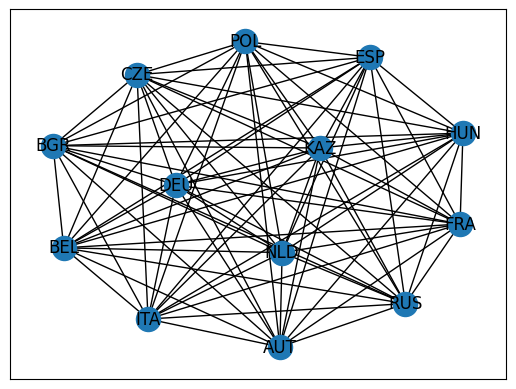

In [71]:
node_list_clique_perm = max(cliques_perm, key=len)

nx.draw_networkx(nx.subgraph_view(G_clique_perm, filter_node=functools.partial(filter_node, node_list=node_list_clique_perm), 
                                  filter_edge=functools.partial(filter_edge, node_list=node_list_clique_perm)), with_labels=True)

And now we look for components

In [56]:
components_perm = [component for component in sorted(nx.connected_components(G_clique_perm), key=len, reverse=False)]
maximal_comp_perm = max(components_perm, key=len)
print(f"The maximal component has size {len(maximal_comp_perm)}")
print(maximal_comp_perm)

The maximal component has size 185
{'RWA', 'AGO', 'DMA', 'GTM', 'MNE', 'GHA', 'BRA', 'TUR', 'BLR', 'ETH', 'CYP', 'PSE', 'GNQ', 'UKR', 'KHM', 'PNG', 'TGO', 'MAC', 'BEL', 'MAR', 'BGR', 'BEN', 'ZAF', 'BTN', 'FRA', 'HTI', 'MDV', 'GIB', 'PAN', 'SOM', 'CRI', 'COD', 'ZWE', 'VCT', 'LUX', 'PRK', 'COM', 'BDI', 'MDG', 'SYC', 'OMN', 'BOL', 'MKD', 'BHS', 'PRT', 'LKA', 'CIV', 'NGA', 'MMR', 'MYS', 'KNA', 'BLZ', 'YEM', 'GUY', 'NOR', 'KGZ', 'USA', 'ABW', 'HND', 'SLE', 'BIH', 'KEN', 'CMR', 'SYR', 'ECU', 'TZA', 'PRY', 'CHN', 'DEU', 'SLB', 'AUT', 'IRQ', 'VEN', 'WSM', 'AUS', 'KAZ', 'GRC', 'POL', 'SEN', 'LTU', 'TJK', 'QAT', 'FIN', 'AND', 'HRV', 'AFG', 'ESP', 'TKM', 'PAK', 'MDA', 'BRB', 'MWI', 'LVA', 'BRN', 'THA', 'COK', 'BFA', 'DOM', 'ISL', 'BHR', 'VNM', 'SLV', 'ARM', 'NER', 'MUS', 'IDN', 'IRN', 'SGP', 'NAM', 'PHL', 'ROU', 'IND', 'SRB', 'LAO', 'AZE', 'CHE', 'CAN', 'URY', 'GMB', 'SSD', 'BGD', 'LBN', 'CUB', 'SUR', 'KOR', 'UZB', 'ARE', 'LBY', 'UGA', 'MOZ', 'PER', 'NIC', 'LSO', 'DNK', 'RUS', 'GAB', 'GEO', 'GRL'

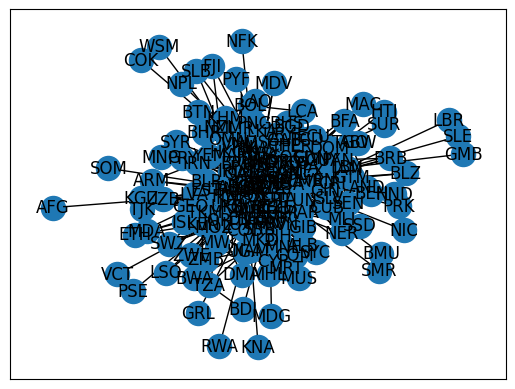

In [70]:
nx.draw_networkx(nx.subgraph_view(G_clique_perm, filter_node=functools.partial(filter_node, node_list=maximal_comp_perm), 
                                  filter_edge=functools.partial(filter_edge, node_list=maximal_comp_perm)), with_labels=True)